In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [14]:
csv_path = os.path.join(os.getcwd(), 'DataSet', 'heart.csv')

df = pd.read_csv(csv_path)

df_copy = df.copy()


In [15]:
print(df_copy.shape)
print(df_copy.dtypes)
print(df_copy.isnull().sum())
print(df_copy.describe())
print(df_copy['HeartDisease'].value_counts())

(918, 12)
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.0

Registros: 918 pacientes | 12 variáveis


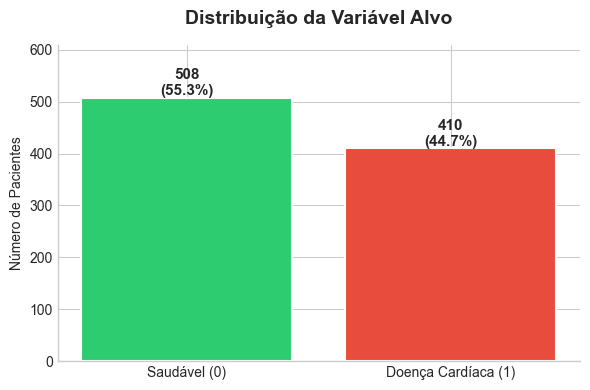


Ratio doente/saudável: 1.24


In [20]:
# ══════════════════════════════════════════════════════════
# Objetivo: entender o tamanho, tipos e balanceamento antes
# de qualquer análise
# ══════════════════════════════════════════════════════════


plt.style.use('seaborn-v0_8-whitegrid')
PALETTE = ['#2ecc71', '#e74c3c']  # verde=saudável, vermelho=doente
sns.set_palette(PALETTE)

print("="*50)
print(f"Registros: {df.shape[0]} pacientes | {df.shape[1]} variáveis")
print("="*50)

# Balanceamento — SEMPRE verificar primeiro
# Se muito desigual, o modelo pode ser enviesado
fig, ax = plt.subplots(figsize=(6, 4))
counts = df['HeartDisease'].value_counts()
bars = ax.bar(['Saudável (0)', 'Doença Cardíaca (1)'], counts.values, color=PALETTE, edgecolor='white', linewidth=1.5)
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{val}\n({val/len(df)*100:.1f}%)', ha='center', fontsize=11, fontweight='bold')
ax.set_title('Distribuição da Variável Alvo', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Número de Pacientes')
ax.set_ylim(0, counts.max() * 1.2)
sns.despine()
plt.tight_layout()
if not os.path.exists('img\eda_01_balanceamento.png'):
    plt.savefig('img\eda_01_balanceamento.png', dpi=150, bbox_inches='tight')
plt.show()

# HISTÓRIA: dataset levemente desbalanceado (55% doentes vs 45% saudáveis)
# Não é crítico, mas justifica o class_weight='balanced' no modelo
print(f"\nRatio doente/saudável: {counts[1]/counts[0]:.2f}")

Verificando valores impossíveis biologicamente:

Colesterol = 0: 0 pacientes
RestingBP  = 0: 0 pacientes
MaxHR      = 0: 0 pacientes


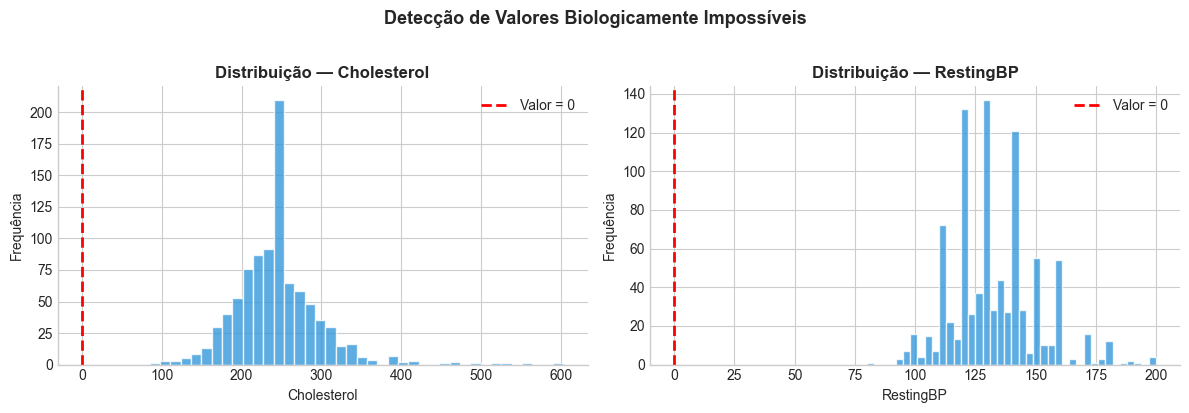


Após tratamento — zeros restantes:
Colesterol: 0
RestingBP:  0


In [21]:
# ══════════════════════════════════════════════════════════
# ATO 2 — TEM ALGO ERRADO?
# Objetivo: encontrar valores impossíveis ou suspeitos.
# Colesterol=0 e RestingBP=0 são impossíveis biologicamente.
# ══════════════════════════════════════════════════════════

print("Verificando valores impossíveis biologicamente:\n")
print(f"Colesterol = 0: {(df['Cholesterol'] == 0).sum()} pacientes")
print(f"RestingBP  = 0: {(df['RestingBP'] == 0).sum()} pacientes")
print(f"MaxHR      = 0: {(df['MaxHR'] == 0).sum()} pacientes")

# Visualizar onde estão os zeros suspeitos
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, col in zip(axes, ['Cholesterol', 'RestingBP']):
    ax.hist(df[col], bins=40, color='#3498db', edgecolor='white', alpha=0.8)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Valor = 0')
    ax.set_title(f'Distribuição — {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequência')
    ax.legend()

plt.suptitle('Detecção de Valores Biologicamente Impossíveis', fontsize=13, fontweight='bold', y=1.02)
sns.despine()
plt.tight_layout()
if not os.path.exists('img\eda_02_anomalias.png'):
    plt.savefig('img\eda_02_anomalias.png', dpi=150, bbox_inches='tight')
plt.show()

# Tratar zeros como NaN e substituir pela mediana por grupo (doente/saudável)
# Mediana por grupo é melhor que mediana geral — preserva o padrão clínico
for col in ['Cholesterol', 'RestingBP']:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df.groupby('HeartDisease')[col].transform(lambda x: x.fillna(x.median()))

df_atualizado = df.copy()   
df_atualizado.to_csv('DataSet/heart_cleaned.csv', index=False)

print("\nApós tratamento — zeros restantes:")
print(f"Colesterol: {df['Cholesterol'].isna().sum()}")
print(f"RestingBP:  {df['RestingBP'].isna().sum()}")

# HISTÓRIA: X pacientes tinham colesterol=0 (impossível biologicamente).
# Substituímos pela mediana do grupo (doente/saudável) para não distorcer o modelo.

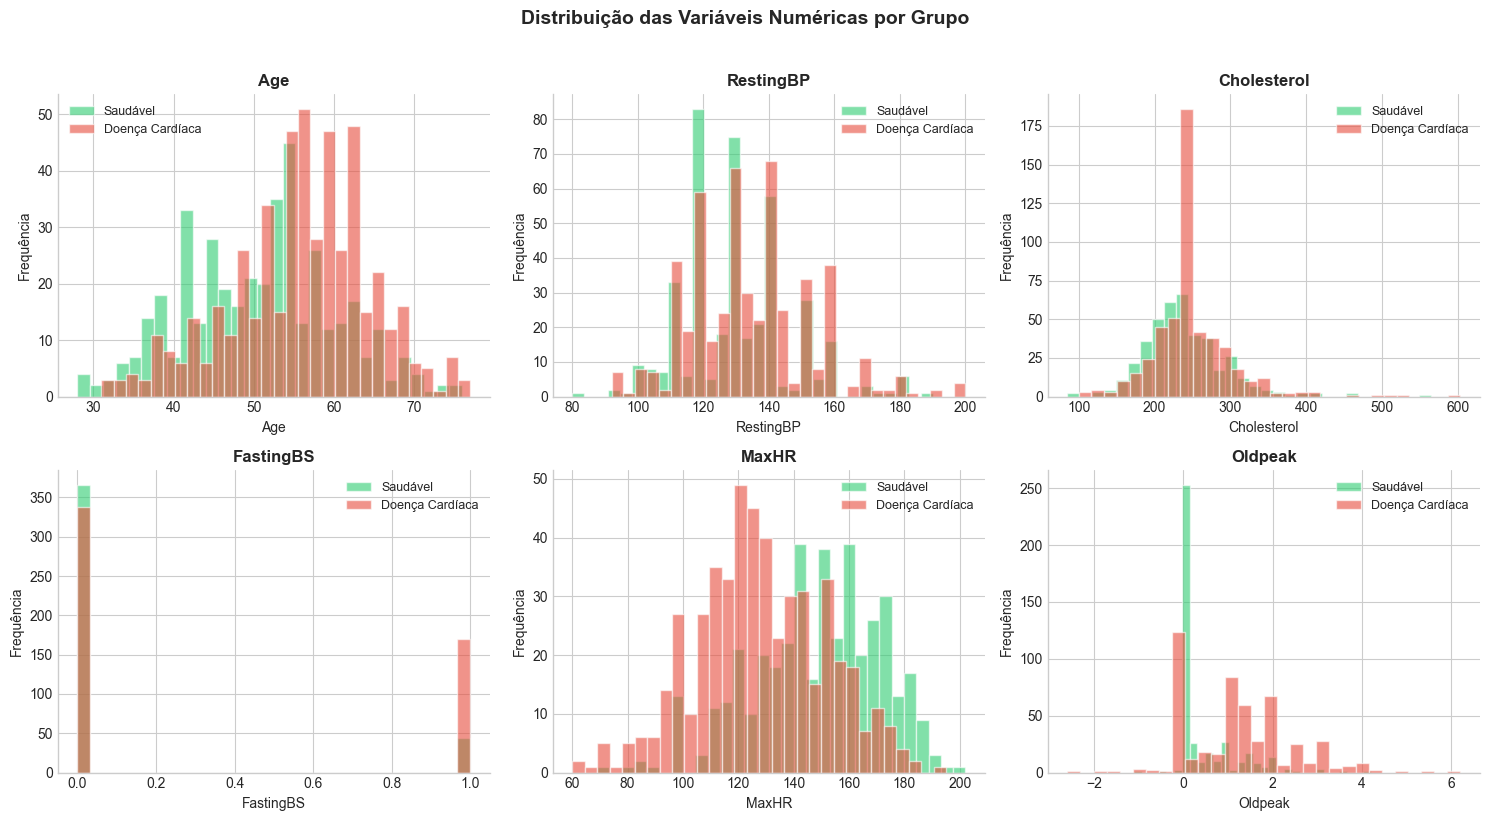

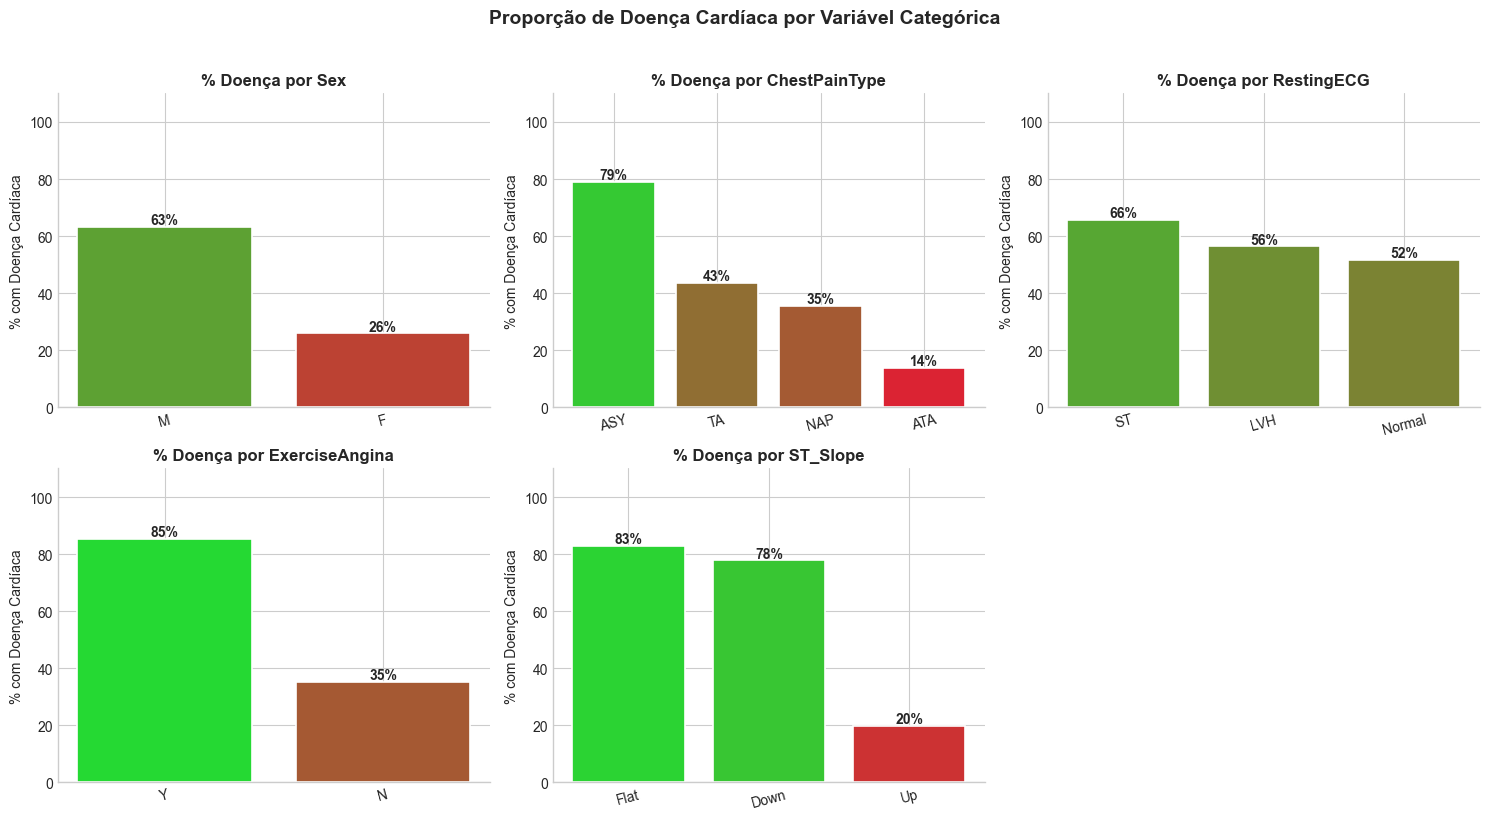

In [ ]:
# ══════════════════════════════════════════════════════════
# ATO 3 — COMO CADA VARIÁVEL SE COMPORTA?
# Objetivo: entender a distribuição de cada feature.
# Gráficos separados por grupo revelam padrões imediatos.
# ══════════════════════════════════════════════════════════

colunas_numericas = ["Age", "RestingBP", "Cholesterol", "FastingBS", "MaxHR", "Oldpeak"]
colunas_categoricas = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

# --- Numéricas: histograma por grupo ---
# Sobrepor saudável e doente no mesmo gráfico conta a história visualmente
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(colunas_numericas):
    for label, color, name in [(0, '#2ecc71', 'Saudável'), (1, '#e74c3c', 'Doença Cardíaca')]:
        axes[i].hist(df[df['HeartDisease'] == label][col],
                     bins=30, alpha=0.6, color=color, label=name, edgecolor='white')
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].legend(fontsize=9)

plt.suptitle('Distribuição das Variáveis Numéricas por Grupo', fontsize=14, fontweight='bold', y=1.02)
sns.despine()
plt.tight_layout()
if not os.path.exists('img\eda_03_numericas.png'):
    plt.savefig('img\eda_03_numericas.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Categóricas: proporção de doença por categoria ---
# Proporção é mais honesta que contagem quando os grupos têm tamanhos diferentes
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(colunas_categoricas):
    prop = df.groupby(col)['HeartDisease'].mean().sort_values(ascending=False)
    bars = axes[i].bar(prop.index, prop.values * 100,
                       color=[f'#{int(255*(1-v)):02x}{int(255*v):02x}33' for v in prop.values],
                       edgecolor='white', linewidth=1.2)
    for bar, val in zip(bars, prop.values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f'{val*100:.0f}%', ha='center', fontsize=10, fontweight='bold')
    axes[i].set_title(f'% Doença por {col}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('% com Doença Cardíaca')
    axes[i].set_ylim(0, 110)
    axes[i].tick_params(axis='x', rotation=15)

axes[-1].set_visible(False)
plt.suptitle('Proporção de Doença Cardíaca por Variável Categórica', fontsize=14, fontweight='bold', y=1.02)
sns.despine()
plt.tight_layout()
if not os.path.exists('img\eda_04_categoricas.png'):
    plt.savefig('img\eda_04_categoricas.png', dpi=150, bbox_inches='tight')
plt.show()

C:\Users\tomat\AppData\Local\Temp\ipykernel_14072\553294149.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_0, data_1],
C:\Users\tomat\AppData\Local\Temp\ipykernel_14072\553294149.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_0, data_1],
C:\Users\tomat\AppData\Local\Temp\ipykernel_14072\553294149.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot([data_0, data_1],
C:\Users\tomat\AppData\Local\Temp\ipykernel_14072\553294149.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since

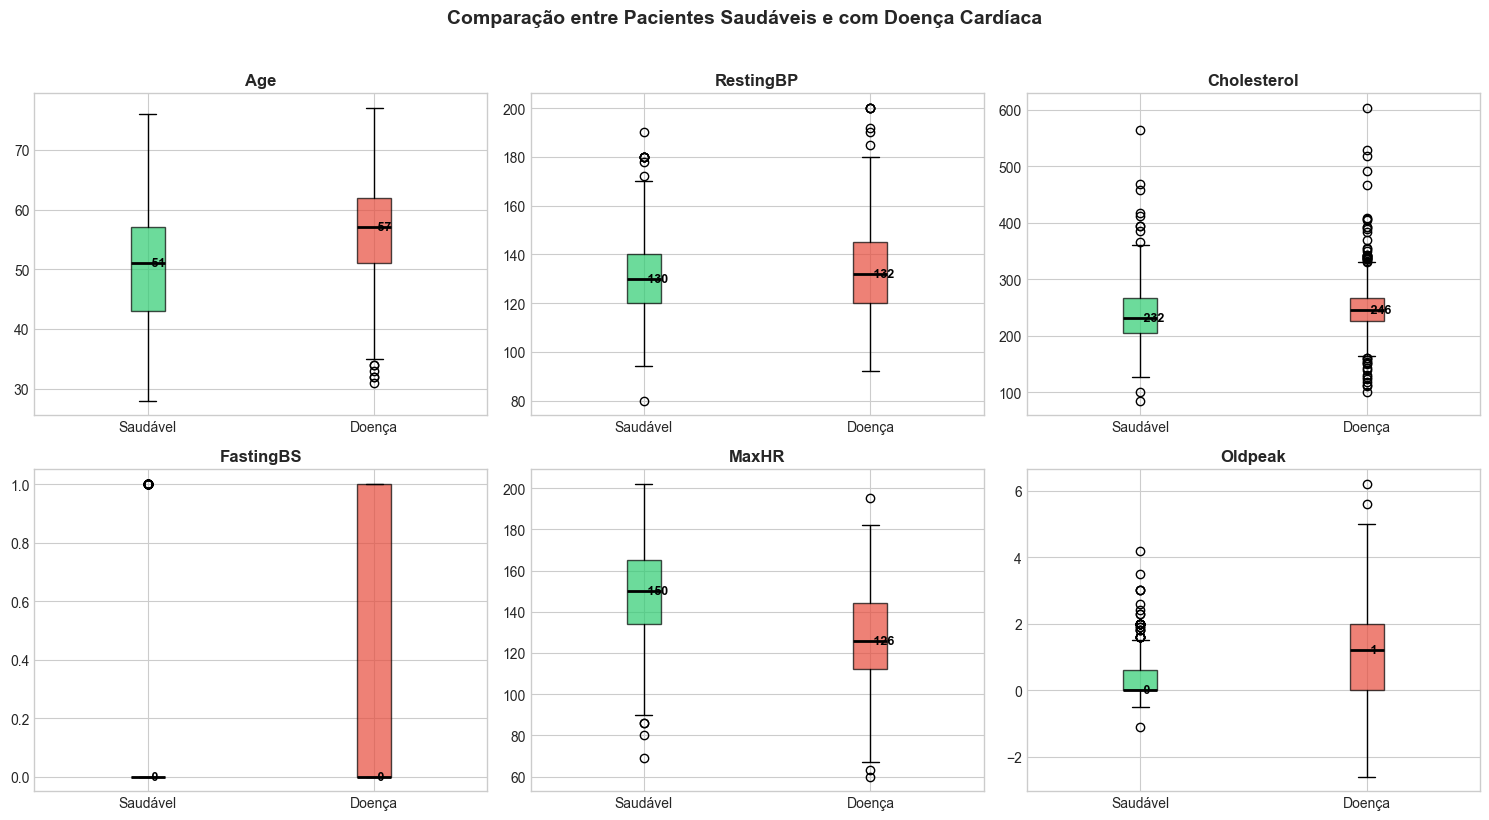

In [ ]:
# ══════════════════════════════════════════════════════════
# ATO 4 — O QUE SEPARA DOENTES DE SAUDÁVEIS?
# Objetivo: contar a história principal do dataset.
# Boxplot é perfeito para isso — mostra mediana e outliers.
# ══════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(colunas_numericas):
    data_0 = df[df['HeartDisease'] == 0][col]
    data_1 = df[df['HeartDisease'] == 1][col]
    bp = axes[i].boxplot([data_0, data_1],
                          patch_artist=True,
                          labels=['Saudável', 'Doença'],
                          medianprops=dict(color='black', linewidth=2))
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][1].set_alpha(0.7)

    # Adiciona a mediana como texto
    for j, data in enumerate([data_0, data_1]):
        axes[i].text(j+1, data.median(), f' {data.median():.0f}',
                     va='center', fontsize=9, color='black', fontweight='bold')

    axes[i].set_title(col, fontsize=12, fontweight='bold')

plt.suptitle('Comparação entre Pacientes Saudáveis e com Doença Cardíaca', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
if not os.path.exists('img\eda_05_compracao.png'):
    plt.savefig('imgzeda_05_comparacao.png', dpi=150, bbox_inches='tight')
plt.show()

# HISTÓRIA para contar:
# - Pacientes com doença têm MaxHR (frequência cardíaca máxima) MENOR
# - Pacientes com doença têm Oldpeak MAIOR
# - Idade média é levemente maior nos doentes
# Esses padrões validam clinicamente o modelo

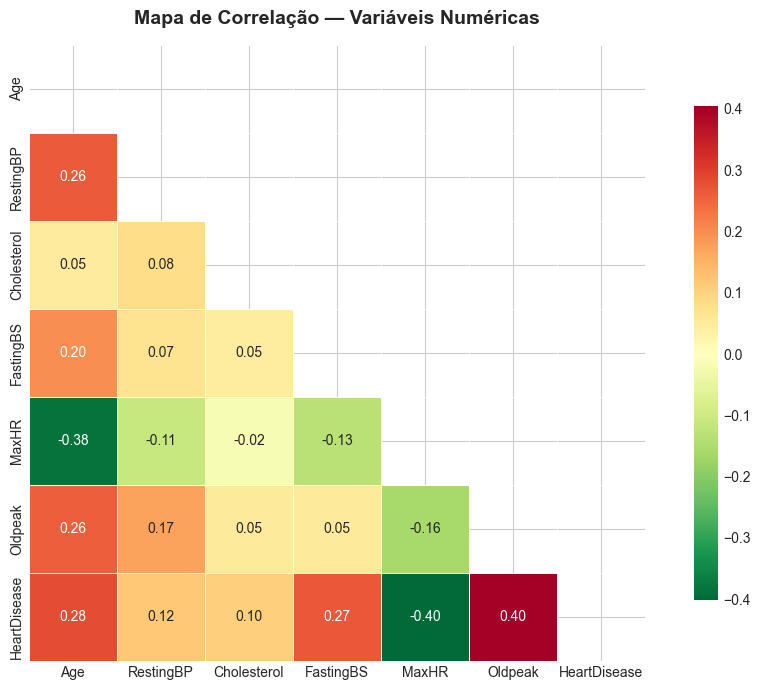


RESUMO ESTATÍSTICO — MEDIANAS POR GRUPO
             Saudável  Doença Cardíaca Diferença %
Age              51.0             57.0       11.8%
RestingBP       130.0            132.0        1.5%
Cholesterol     231.5            246.0        6.3%
FastingBS         0.0              0.0        nan%
MaxHR           150.0            126.0      -16.0%
Oldpeak           0.0              1.2        inf%


In [ ]:
# ══════════════════════════════════════════════════════════
# ATO 5 — O QUE MAIS INFLUENCIA O RISCO?
# Objetivo: fechar a história com correlações e feature importance.
# Heatmap mostra relação entre variáveis numéricas.
# ══════════════════════════════════════════════════════════

# Heatmap de correlação
fig, ax = plt.subplots(figsize=(10, 7))
corr = df[colunas_numericas + ['HeartDisease']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))  # esconde triângulo superior (redundante)

sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlGn_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})

ax.set_title('Mapa de Correlação — Variáveis Numéricas', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
if not os.path.exists('img\eda_06_correlacao.png'):
    plt.savefig('img\eda_06_correlacao.png', dpi=150, bbox_inches='tight')
plt.show()

# Resumo estatístico por grupo — tabela profissional
print("\n" + "="*60)
print("RESUMO ESTATÍSTICO — MEDIANAS POR GRUPO")
print("="*60)
resumo = df.groupby('HeartDisease')[colunas_numericas].median().T
resumo.columns = ['Saudável', 'Doença Cardíaca']
resumo['Diferença %'] = ((resumo['Doença Cardíaca'] - resumo['Saudável']) / resumo['Saudável'] * 100).round(1).astype(str) + '%'
print(resumo.to_string())